# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center> Визуальный анализ данных и построение признаков


**План недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков


## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import plotly.offline as offline
import plotly.graph_objs as go
import plotly

In [3]:
from more_itertools import unique_everseen
from dateutil import parser

In [4]:
import matplotlib
matplotlib.rc('font', family='Verdana')

In [5]:
# путь к данным
PATH_TO_DATA = 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\capstone_user_identification'
PATH_TO_DICT= 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\pkls'

**Создадим на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), которая создает следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция возвращает новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    users=[]
    for_df=[]
    times_diff=[]
    all_times=[]
    os.chdir(path_to_csv_files) 
    with open(site_freq_path, 'rb') as f:
        vocabulary = pickle.load(f)
    allFiles = glob.glob('user*.csv')
    for file_ in allFiles:
        with open(file_) as f:
            user_id=file_.split('.csv')[0].lstrip('user0')
            for row in f.readlines(): 
                word=row.split(',')[1].strip()
                time=row.split(',')[0].strip()
                if word!='site' and time!='timestamp':
                    users.append(user_id)
                    all_times.append(parser.parse(time))
                    for_df.append(word)
            if len(for_df)%session_length!=0:
                for_df.extend(np.zeros(session_length-len(for_df)%session_length).astype('int'))
                all_times.extend(np.zeros(session_length-len(all_times)%session_length).astype('int'))
    all_times=np.array(all_times).reshape(int(len(all_times)/session_length),session_length)
    for row in all_times:
        for i in range(0,len(row)-1):
            if row[i]!=0 and row[i+1]!=0:
                times_diff.append((row[i+1]-row[i]).seconds)
            else:
                times_diff.append(0)
    for_df=list(map(lambda x: vocabulary[x][1] if x!=0 else 0,for_df))
    sites=np.array(for_df).reshape(int(len(for_df)/session_length),session_length)
    times_diff=np.array(times_diff).reshape(int(len(times_diff)/(session_length-1)),session_length-1)
    timespans=[np.sum(i) for i in times_diff]
    unique_sites=list(map(lambda x: len(np.unique(x))-1 if i!=0 in x else len(np.unique(x)),sites))
    start_hours=np.array([all_times[i][0].hour for i in range(len(all_times))])
    day_of_week=np.array([all_times[i][0].weekday() for i in range(len(all_times))])
    users=np.array(users)
    users_df=[]
    for user in list(unique_everseen(users)):
        t=users[users==user]
        if len(t)%session_length==0:
            users_df.extend([user]*int((len(t)/session_length)))
        else:
            users_df.extend([user]*int((len(t)/session_length)+1))
    l=len(timespans)
    for_df=np.hstack((sites,times_diff,np.array(timespans).reshape(l,1),
                  np.array(unique_sites).reshape(l,1), start_hours.reshape(l,1),
                 day_of_week.reshape(l,1),np.array(users_df).reshape(l,1)))
    df=pd.DataFrame(for_df, columns=feature_names)
    return df

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DICT, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Применим функцию *prepare_train_set_with_fe* к данным по 10 пользователям,  *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DICT, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 11.4 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Применим функцию *prepare_train_set_with_fe* к данным по 150 пользователям, *session_length*=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DICT, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 2min 19s


In [13]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1290,321,1,1,1,4,0,1,0,49,0,57,5,8,4,6
1,2,23,1505,1290,321,321,113,73,49,49,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6
2,321,205,1,1,1,1,73,321,2,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6
3,1,1,6998,6998,5491,6998,6998,1,35,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,4,3,0,1,0,1,0,1,0,10,5,9,4,6


**Сохраним в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [13]:
new_features_10users = train_data_10users.iloc[:,19:-1]
new_features_150users = train_data_150users.iloc[:,19:-1]

In [14]:
with open(os.path.join(PATH_TO_DICT, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DICT, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [14]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [15]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [16]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [17]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [10]:
train_data_10users['target']=train_data_10users['target'].astype('int')

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0.5,1,'Распределение длины сессии в секундах(session_timespan)')

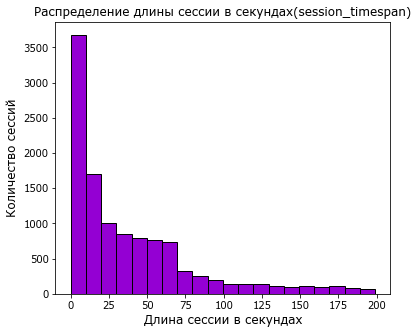

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
plt.hist(train_data_10users['session_timespan'][train_data_10users.session_timespan.astype('int')<200].astype('int'),
             color='darkviolet',edgecolor = 'black',bins=20)
ax.set_xlabel('Длина сессии в секундах', fontsize=12)
ax.set_ylabel('Количество сессий', fontsize=12)
plt.title('Распределение длины сессии в секундах(session_timespan)')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5,1,'Распределение числа уникальных сайтов(#unique_sites)')

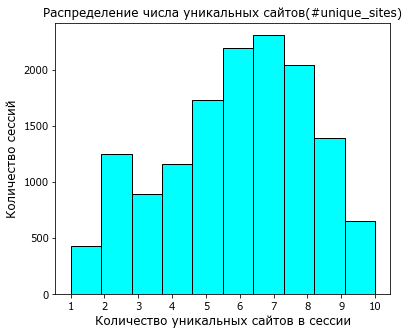

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
plt.hist(train_data_10users['#unique_sites'].astype('int'),color='aqua',edgecolor = 'black')
plt.xticks(np.arange(1,11,1))
ax.set_xlabel('Количество уникальных сайтов в сессии', fontsize=12)
ax.set_ylabel('Количество сессий', fontsize=12)
plt.title('Распределение числа уникальных сайтов(#unique_sites)')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

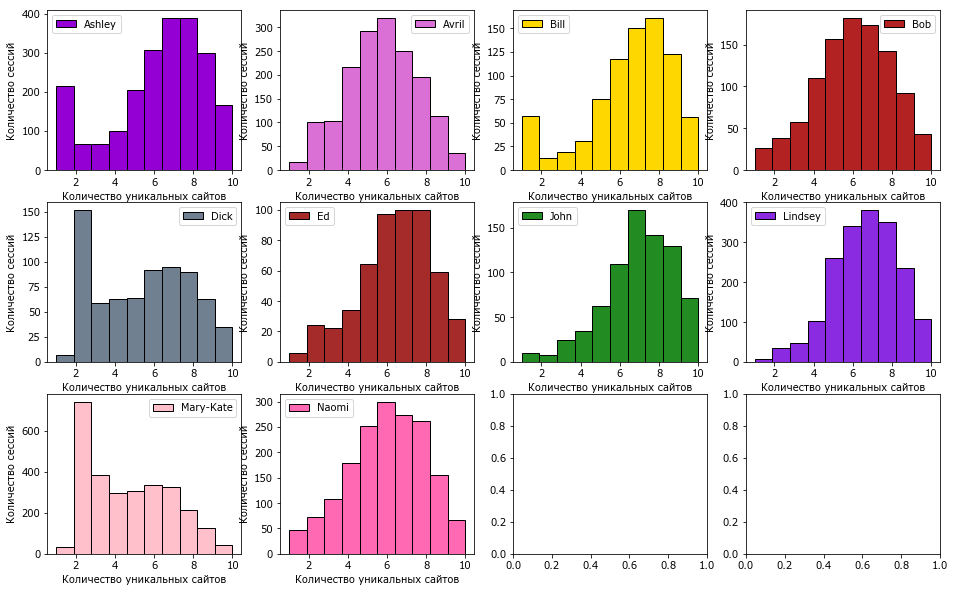

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.hist(sub_df['#unique_sites'].astype('int'),color=color_dic[user],label=user, ec='black')    
    ax.legend()
    ax.set_xlabel('Количество уникальных сайтов')
    ax.set_ylabel('Количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0.5,1,'Распределение часа начала сессии(start_hour)')

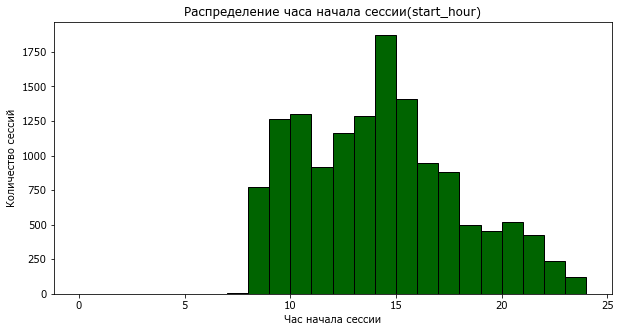

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
train_data_10users['start_hour'].astype('int').hist(color='darkgreen',
                                           bins=24,range=(0,24),ec='black', grid=False)
ax.set_xlabel('Час начала сессии')
ax.set_ylabel('Количество сессий');
plt.title('Распределение часа начала сессии(start_hour)')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

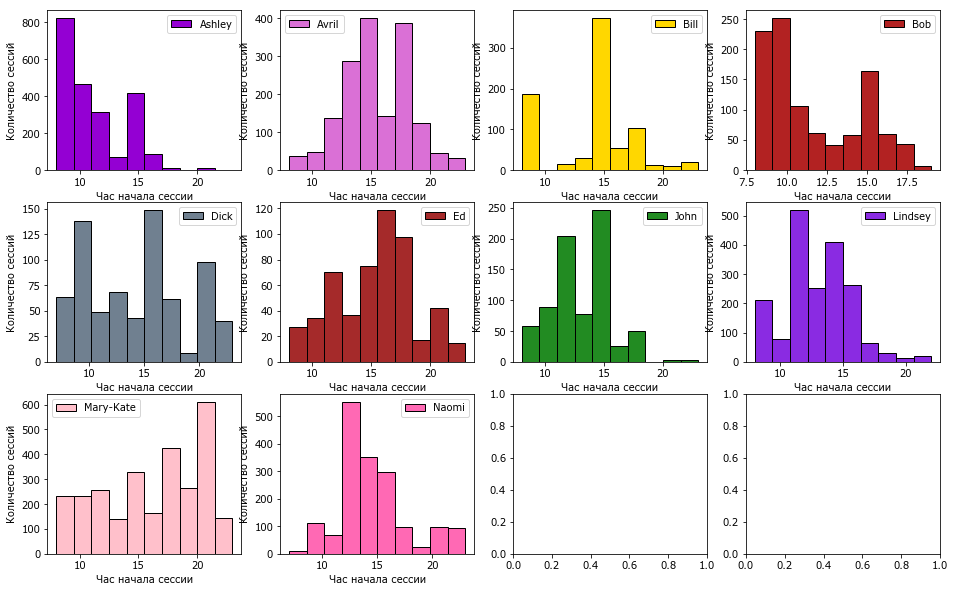

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.hist(sub_df['start_hour'].astype('int'),color=color_dic[user],label=user, ec='black')    
    ax.legend()
    ax.set_xlabel('Час начала сессии')
    ax.set_ylabel('Количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0.5,1,'Распределение дня недели начала сессии(day_of_week)')

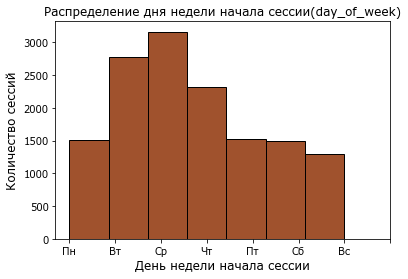

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
plt.hist(train_data_10users['day_of_week'].astype('int'),color='sienna',edgecolor = 'black', bins=7)
days=['Пн','Вт','Ср','Чт','Пт','Сб', 'Вс']
ax.set_xticklabels(days)
plt.xticks(range(0,8))
ax.set_xlabel('День недели начала сессии', fontsize=12)
ax.set_ylabel('Количество сессий', fontsize=12)
plt.title('Распределение дня недели начала сессии(day_of_week)')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

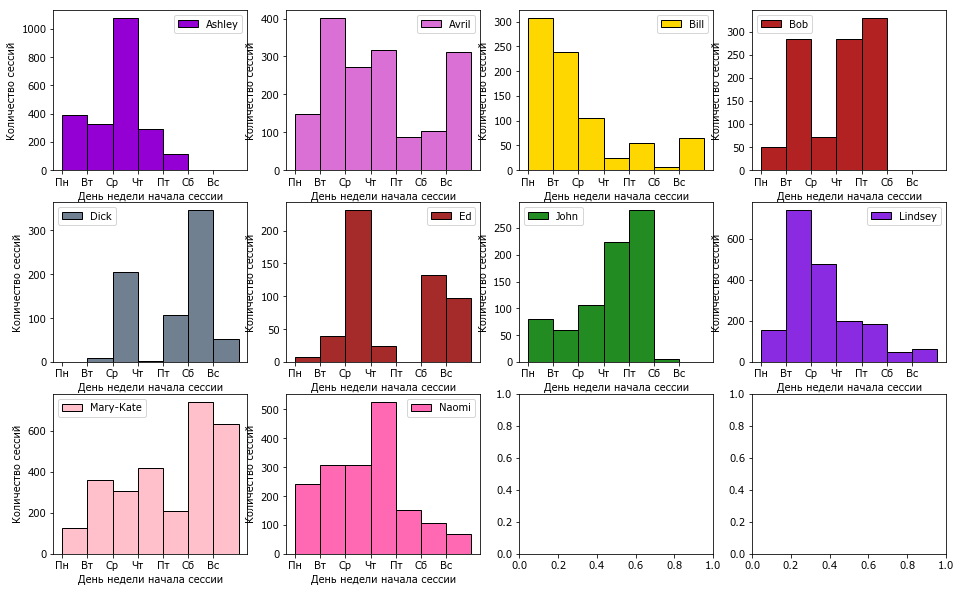

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
days=['Пн','Вт','Ср','Чт','Пт','Сб', 'Вс']

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.hist(sub_df['day_of_week'].astype('int'),color=color_dic[user],label=user, ec='black',bins=np.arange(0.,8.))  
    ax.set_xticks(range(len(days)))
    ax.set_xticklabels(days)
    ax.legend()  
    ax.set_xlabel('День недели начала сессии')
    ax.set_ylabel('Количество сессий')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Длина сессии по большей части находится в пределах 10-15 секунд.
Количество уникальных сайтов в сессии как в общем, так и по пользователям в большинстве находится в промежутке от 6 до 8 сайтов, однако есть два пользователя, у которых в основном только 2 уникальных сайта в сессиях.
Распределения признаков час начала и день начала сессии у разных пользователей значительно отличаются, что выделяет их уникальность и, возможно, поможет при идентификации.
Ashley посещает порядка 6-8 уникальных сайтов за сессию, проявляет бОльшую активность утром, большинство сессий в середине недели.
Avril  посещает порядка 6-8 уникальных сайтов за сессию, проявляет активность днем-вечером, большинство сессий во вторник и воскресение.
Bill  посещает порядка 6-8 уникальных сайтов за сессию, пик активности выпадает на 3 часа дня, большинство сессий в начале недели.
Bob  посещает порядка 6-8 уникальных сайтов за сессию, проявляет бОльшую активность утром, днем она меньше, большинство сессий во вторник и четверг-пятницу, в выходные активности нет.
Dick посещает только около 2 уникальных сайтов в сессию, пики активности есть и днем, и утром, и вечером, большинство сессий в субботу.
Ed посещает порядка 6-8 уникальных сайтов за сессию, основную активность проявляет днем, большинство сессий в среду.
John посещает порядка 6-8 уникальных сайтов за сессию, основную активность проявляет днем, большинство сессий в пятницу-субботу.
Lindsey посещает порядка 6-8 уникальных сайтов за сессию, активность выпадает на утро-день, большинство сессий во вторник-среду.
Mary-Kate посещает только около 2 уникальных сайтов в сессию, большая часть активности выпадает на вечер, большинство сессий в выходные.
Naomi посещает порядка 6-8 уникальных сайтов за сессию, основную активность проявляет днем, большинство сессий в четверг.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [23]:
with open(os.path.join(PATH_TO_DICT,'site_freq_10users.pkl'), 'rb') as f:
        vocabulary_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [24]:
top10_sites = list(vocabulary_10users.keys())[0:10]
top10_freqs = [vocabulary_10users[i][0] for i in top10_sites ]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

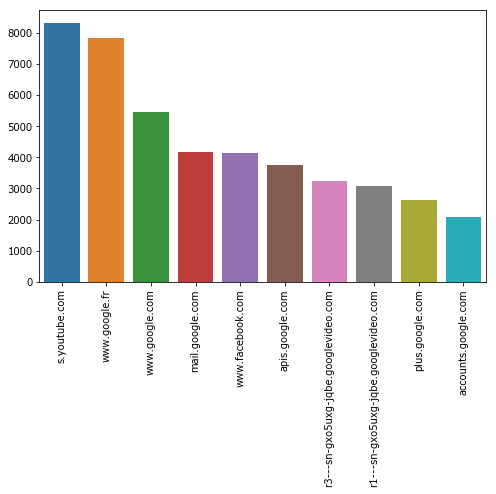

In [25]:
plt.figure(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.barplot(x=top10_sites,y=top10_freqs)

## Часть 3. Дальнейшее построение признаков

Новые признаки:
- время суток начала сессии: 0-ночь, 1-утро, 2-день, 3-вечер
- среднее время, проведенное на сайте в секундах
- количество сайтов из топ 30, посещенных в сессию

In [22]:
def feature_engineering(path_to_csv_files,site_freq_path, features, session_length=10):
    users=[]
    for_df=[]
    times_diff=[]
    all_times=[]
    os.chdir(path_to_csv_files)
    with open(site_freq_path, 'rb') as f:
        vocabulary = pickle.load(f)
    allFiles = glob.glob('user*.csv')
    for file_ in allFiles:
        with open(file_) as f:
            user_id=file_.split('.csv')[0].lstrip('user0')
            for row in f.readlines(): 
                word=row.split(',')[1].strip()
                time=row.split(',')[0].strip()
                if word!='site' and time!='timestamp':
                    users.append(user_id)
                    all_times.append(parser.parse(time))
                    for_df.append(word)
            if len(for_df)%session_length!=0:
                for_df.extend(np.zeros(session_length-len(for_df)%session_length).astype('int'))
                all_times.extend(np.zeros(session_length-len(all_times)%session_length).astype('int'))
    all_times=np.array(all_times).reshape(int(len(all_times)/session_length),session_length)
    for row in all_times:
        for i in range(0,len(row)-1):
            if row[i]!=0 and row[i+1]!=0:
                times_diff.append((row[i+1]-row[i]).seconds)
            else:
                times_diff.append(0)
    for_df=list(map(lambda x: vocabulary[x][1] if x!=0 else 0,for_df))
    sites=np.array(for_df).reshape(int(len(for_df)/session_length),session_length)
    times_diff=np.array(times_diff).reshape(int(len(times_diff)/(session_length-1)),session_length-1)
    timespans=[np.sum(i) for i in times_diff]
    mean_time=list(map(lambda x:int(round(np.sum(x)/np.count_nonzero(x))) if np.count_nonzero(x)!=0 else 0,
                      times_diff))
    #mean_time=[int(round(np.sum(row)/np.count_nonzero(row))) for row in times_diff if np.count_nonzero(row)!=0 else: 0]
    unique_sites=list(map(lambda x: len(np.unique(x))-1 if i!=0 in x else len(np.unique(x)),sites))
    start_hours=np.array([all_times[i][0].hour for i in range(len(all_times))])
    counts_top30=list(map(lambda x: len(x[x<30]),sites))
    time_of_day=list(map(lambda x: 1 if (x>=6 and x<=11) else 2 if (x>=12 and x<=16) else 3 if (x>=17 and x<=22) else 0,
         start_hours.astype('int')))
    day_of_week=np.array([all_times[i][0].weekday() for i in range(len(all_times))])
    users=np.array(users)
    users_df=[]
    for user in list(unique_everseen(users)):
        t=users[users==user]
        if len(t)%session_length==0:
            users_df.extend([user]*int((len(t)/session_length)))
        else:
            users_df.extend([user]*int((len(t)/session_length)+1))
    l=len(timespans)
    for_df=np.hstack((sites,times_diff,np.array(timespans).reshape(l,1),
                  np.array(unique_sites).reshape(l,1), start_hours.reshape(l,1),
                 day_of_week.reshape(l,1),np.array(time_of_day).reshape(l,1),
                   np.array(mean_time).reshape(l,1),np.array(counts_top30).reshape(l,1),   
                      np.array(users_df).reshape(l,1)))
    df=pd.DataFrame(for_df,columns=features)
    return df

In [23]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week','time_of_day','mean_time','count_top30', 'target']
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DICT, 
                                'site_freq_10users.pkl'),
                  features=feature_names, session_length=10) 

In [29]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,time_of_day,mean_time,count_top30,target
0,192,574,133,3,133,133,3,133,203,133,10,0,...,1,0,1,0,33,5,8,4,1,7,2,John
1,415,193,674,254,133,31,393,3305,217,55,1,0,...,1,3,3,8,284,10,8,4,1,41,0,John
2,55,3,55,55,5,293,415,333,897,55,0,14,...,0,1,0,0,258,7,8,4,1,64,2,John
3,473,3306,473,55,55,55,55,937,199,123,2,1,...,1,0,0,0,30,6,8,4,1,6,0,John
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,...,0,1,1,0,6,9,8,4,1,1,1,John


In [226]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DICT, 
                                'site_freq_150users.pkl'),
                  features=feature_names, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [24]:
new_features_10users['target']=new_features_10users['target'].astype('int')

In [25]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [26]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

Text(0.5,1,'Распределение среднего времени на сайте(mean_time)')

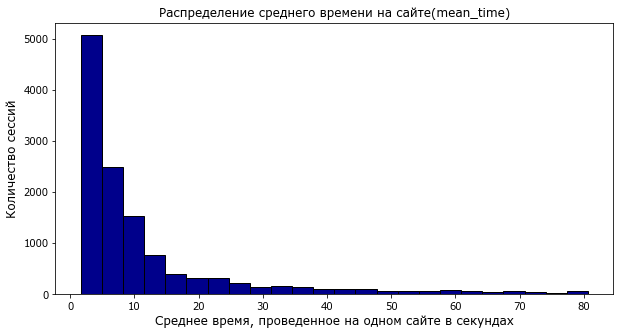

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
new_features_10users['mean_time'][new_features_10users.mean_time.astype('int')<80].astype('int').hist(
                                            color='darkblue',
                                           bins=24,align='right',ec='black', grid=False)
ax.set_xlabel('Среднее время, проведенное на одном сайте в секундах', fontsize=12)
ax.set_ylabel('Количество сессий', fontsize=12)
plt.title('Распределение среднего времени на сайте(mean_time)')

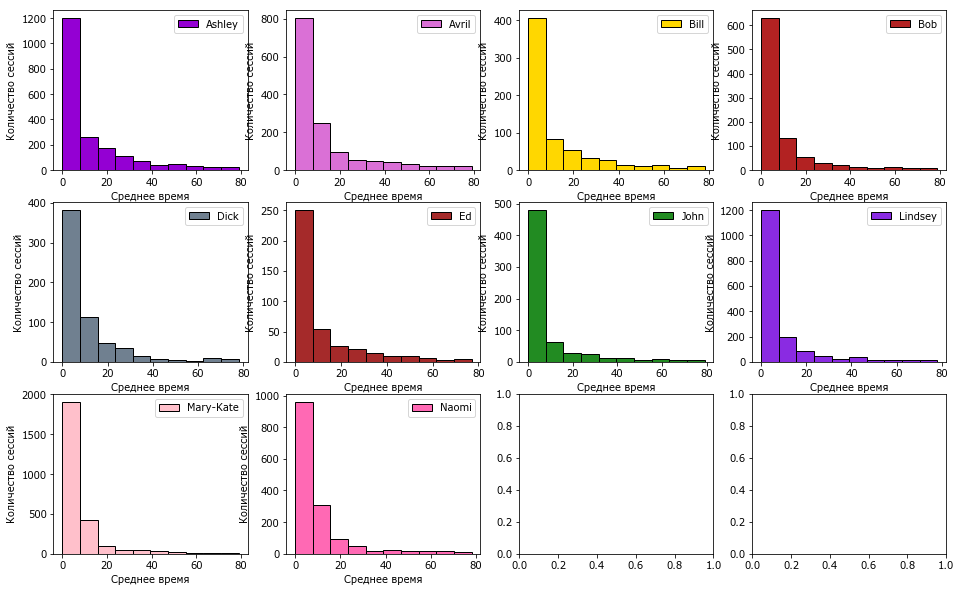

In [276]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.hist(sub_df['mean_time'][new_features_10users.mean_time.astype('int')<80].astype('int'),
            color=color_dic[user],label=user, ec='black')    
    ax.legend()
    ax.set_xlabel('Среднее время')
    ax.set_ylabel('Количество сессий')

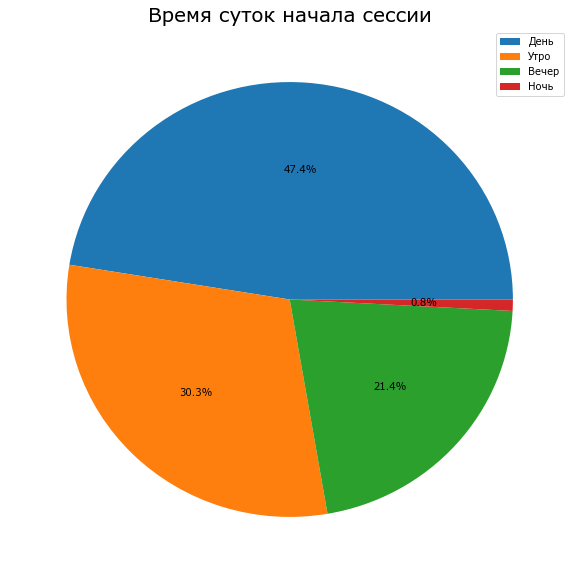

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
dict_label = {'0':'Ночь', '1':'Утро', '2':'День', '3':'Вечер'}
labels = list(map(lambda x: dict_label[x], new_features_10users.time_of_day.value_counts().index))
ax.pie(new_features_10users.time_of_day.value_counts(),autopct='%1.1f%%')
ax.set_title('Время суток начала сессии',fontsize=20)
ax.legend(list(map(lambda x: dict_label[x], new_features_10users.time_of_day.value_counts().index)))

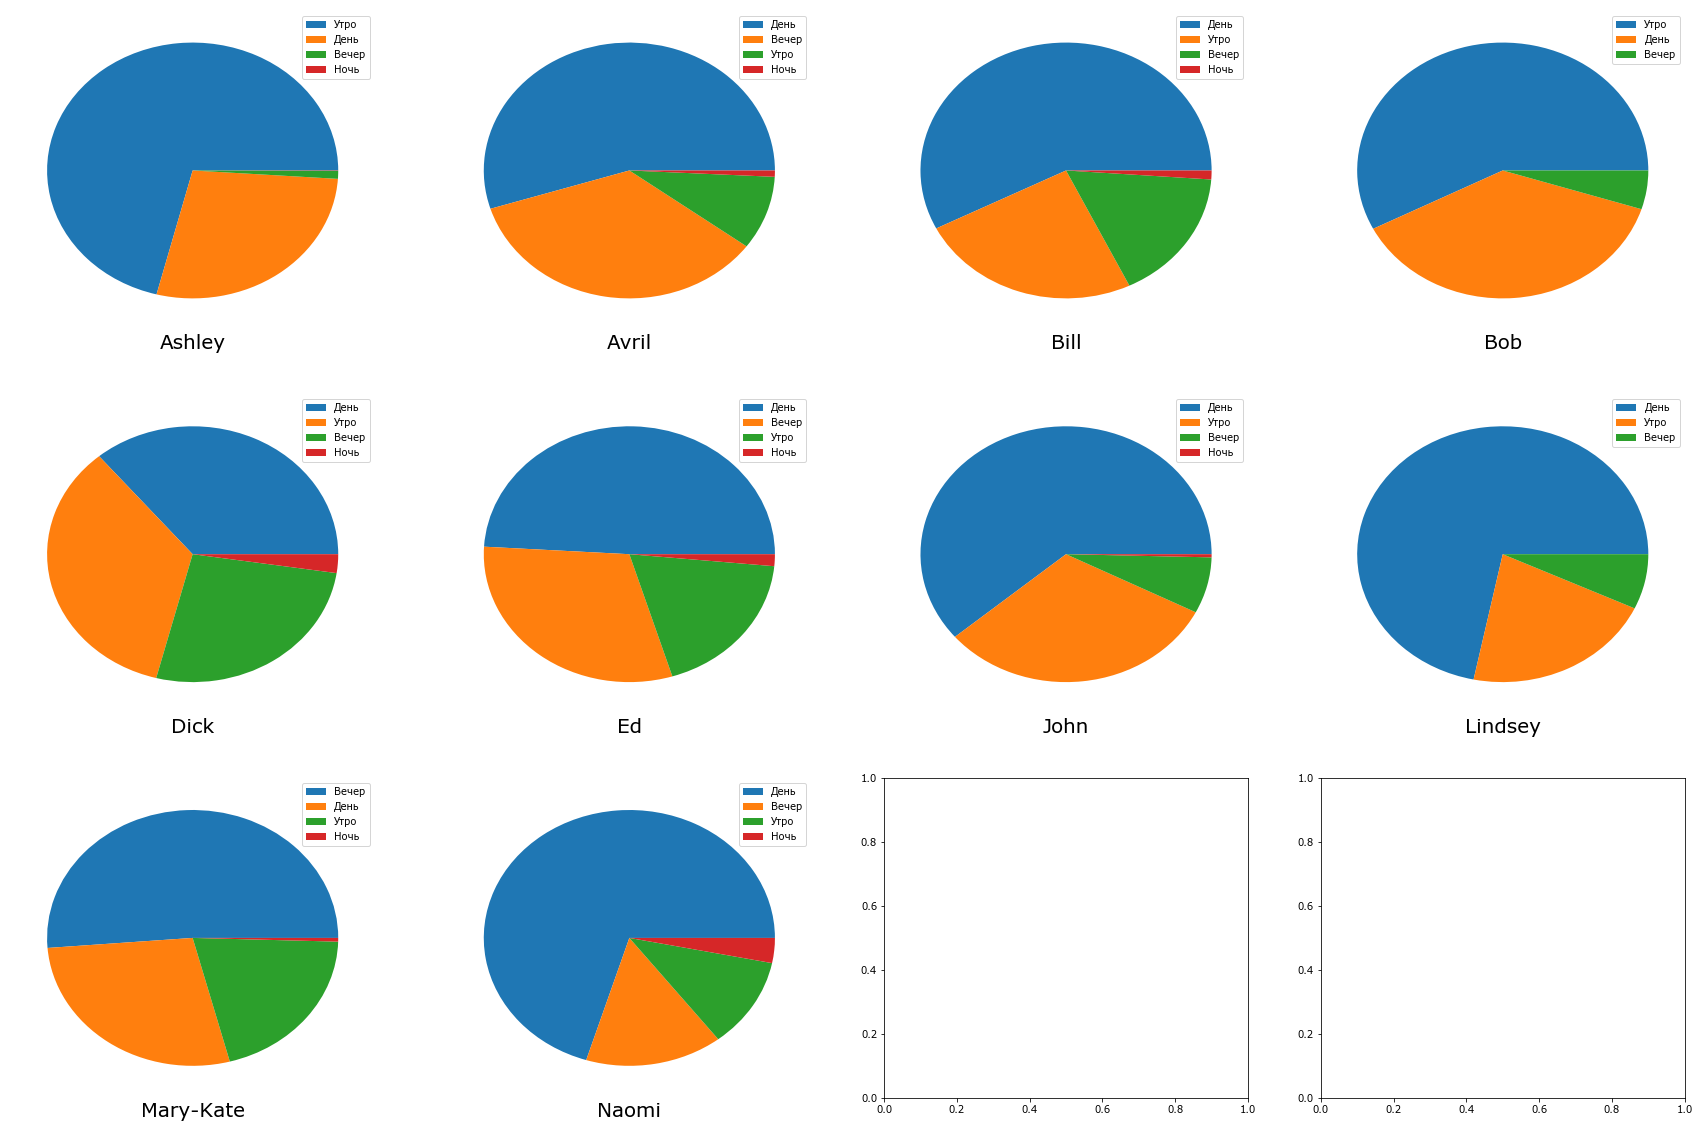

In [357]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
dict_label = {'0':'Ночь', '1':'Утро', '2':'День', '3':'Вечер'}

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.pie(sub_df['time_of_day'].value_counts())
    ax.set_xlabel(user,fontsize=20)
    ax.legend(list(map(lambda x: dict_label[x], sub_df.time_of_day.value_counts().index)))



Text(0.5,1,'Распределение количества сайтов из топ-30(count_top30)')

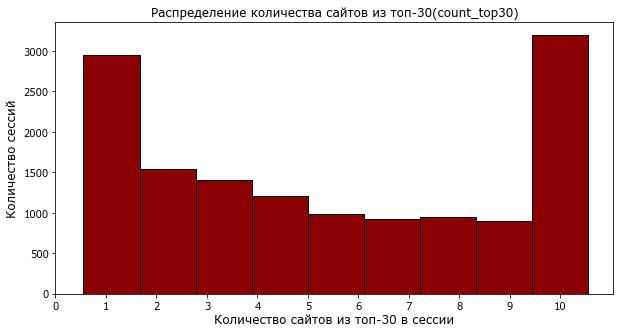

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
new_features_10users['count_top30'].astype('int').hist(
                                            color='darkred',
                                           bins=9,align='right',ec='black', grid=False)
ax.set_xticks(range(0,11))
ax.set_xlabel('Количество сайтов из топ-30 в сессии', fontsize=12)
ax.set_ylabel('Количество сессий', fontsize=12)
plt.title('Распределение количества сайтов из топ-30(count_top30)')

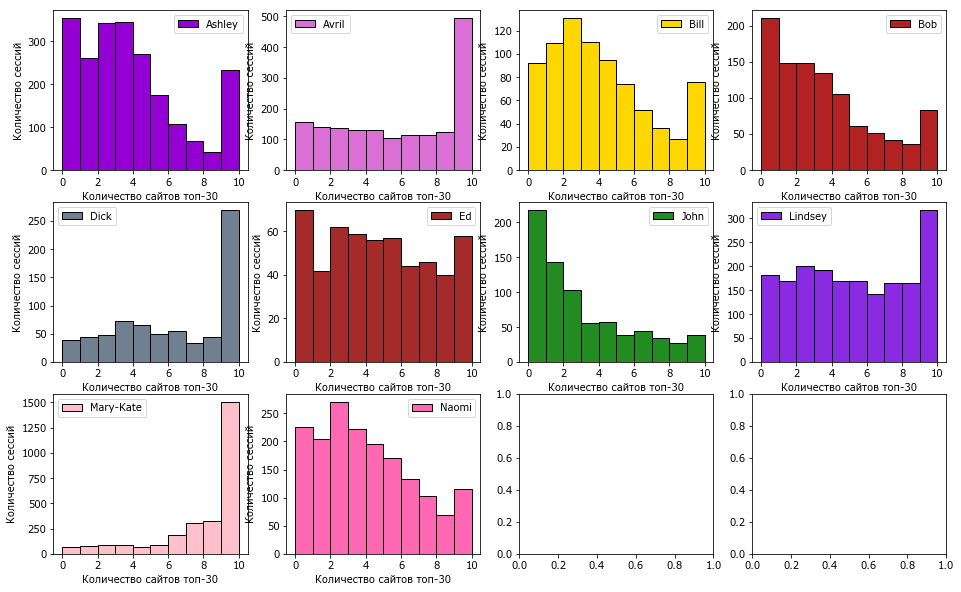

In [340]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[int(idx/4),idx%4]
    ax.hist(sub_df['counts_top30'].astype('int'),
            color=color_dic[user],label=user, ec='black')    
    ax.legend()
    ax.set_xlabel('Количество сайтов топ-30')
    ax.set_ylabel('Количество сессий')

Вывод: Для сета в целом чаще всего сессии начинаются днем, по пользователям картина схожая, но есть пользователи, у которых сессии чаще начинаются утром() или вечером(). 
Количество сайтов из топ-30 в сессии по пользователям распределяется по разному: есть пользователи, которые предпочитают популярные сайты, а есть те, кто наоборот на них почти не заходит.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [362]:
selected_features_10users = new_features_10users.iloc[:,19:-1]
selected_features_150users = new_features_150users.iloc[:,19:-1]

In [363]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)